In [9]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2023-08-06 12:54:26--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2023-08-06 12:54:27--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz.1’

images.tar.gz.1     100%[===================>] 755.23M  32.2MB/s    in 24s     

2023-08-06 12:54:52 (30.9 MB/s) - ‘images.tar.gz.1’ saved [791918971/791918971]

--2023-08-06 12:54:53--  https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox

In [12]:
!gunzip images.tar.gz
!tar -xf images.tar

!gunzip annotations.tar.gz
!tar -xf annotations.tar

^C


In [13]:
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

tar: images.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
tar: annotations.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [25]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of input samples:", len(input_img_paths))
print("Number of output samples:", len(target_img_paths))


for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of input samples: 7390
Number of output samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


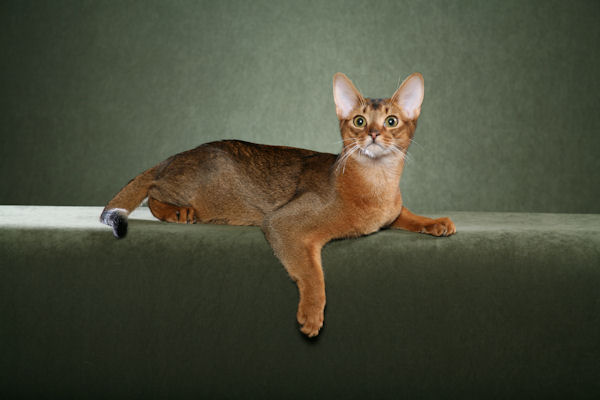

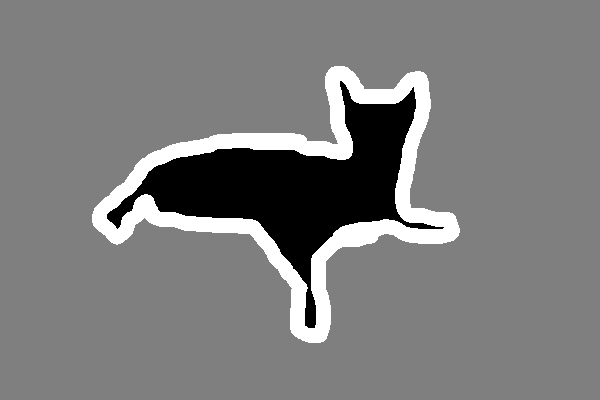

In [27]:
from IPython.display import Image, display
from tensorflow.keras.utils import load_img
from PIL import ImageOps

display(Image(filename=input_img_paths[0]))

img = ImageOps.autocontrast(load_img(target_img_paths[0]))
display(img)

In [28]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.utils import load_img

In [47]:
class OxfordPets(keras.utils.Sequence):
    def __init__(self, batch_size, image_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        
    def __len__(self):
        return len(self.input_img_paths) // batch_size
    
    def __getitem__(self, idx):
        i = idx * self.batch_size
        
        batch_input_img_paths = self.input_img_paths[i: i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i: i + self.batch_size]
        
        x = np.zeros((batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
            
        y = np.zeros((batch_size, ) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            y[j] -= 1
        return x, y        

In [34]:
from tensorflow.keras import layers


def get_model(img_size, num_classes, features: list):
    inputs = keras.Input(shape=img_size + (3,))
    
    x = layers.Conv2D(features[0], 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    
    previous_block_activation = x
    
    for filters in features[1:]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x
        
    for filters in reversed(features):
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.UpSampling2D(2)(x)
        
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])
        previous_block_activation = x
        
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    model = keras.Model(inputs, outputs)
    return model
    

In [35]:
keras.backend.clear_session()

In [36]:
model = get_model(img_size, num_classes, [32, 64, 128, 256])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 80, 80, 32)           896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 80, 80, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 80, 80, 32)           0         ['batch_normalization[0][0

In [97]:
import random

val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

In [98]:
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

In [49]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15


2023-08-06 13:55:44.573884: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-06 13:55:48.228864: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7efc45142e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-06 13:55:48.228919: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-08-06 13:55:48.237912: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-06 13:55:48.394332: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


199/199 [==============================] - ETA: 0s - loss: 0.9429

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


199/199 [==============================] - 52s 158ms/step - loss: 0.9429 - val_loss: 3.1174
Epoch 2/15
199/199 [==============================] - 31s 153ms/step - loss: 0.5111 - val_loss: 1.9114
Epoch 3/15
199/199 [==============================] - 31s 155ms/step - loss: 0.4379 - val_loss: 0.4799
Epoch 4/15
199/199 [==============================] - 31s 153ms/step - loss: 0.3969 - val_loss: 0.3934
Epoch 5/15
199/199 [==============================] - 30s 152ms/step - loss: 0.3627 - val_loss: 0.4363
Epoch 6/15
199/199 [==============================] - 30s 152ms/step - loss: 0.3358 - val_loss: 0.4012
Epoch 7/15
199/199 [==============================] - 31s 153ms/step - loss: 0.3139 - val_loss: 0.3794
Epoch 8/15
199/199 [==============================] - 30s 152ms/step - loss: 0.2898 - val_loss: 0.3937
Epoch 9/15
199/199 [==============================] - 31s 153ms/step - loss: 0.2705 - val_loss: 0.3672
Epoch 10/15
199/199 [==============================] - 29s 147ms/step - loss: 0.2543

In [57]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 80, 80, 32)           896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 80, 80, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 80, 80, 32)           0         ['batch_normalization[0][0

31/31 [==============================] - 5s 142ms/step


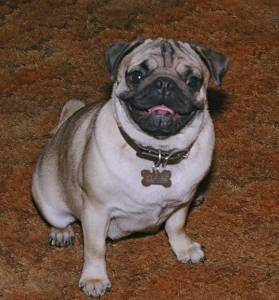

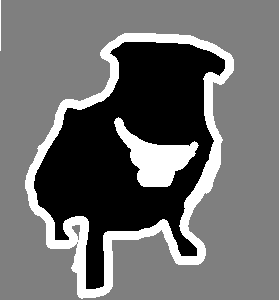

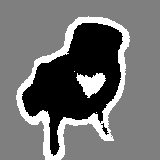

In [50]:
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)


i = 10

display(Image(filename=val_input_img_paths[i]))

img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

display_mask(i)

In [107]:
def make_double_conv_layer(x, filters, skip_connection=None):        
    x = layers.Conv2D(filters, 3, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    if skip_connection is not None:
        x = layers.add([x, skip_connection])

    x = layers.Conv2D(filters, 3, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x


def make_unet(img_size, num_classes, features: list = [32, 64, 128, 256]):
    inputs = layers.Input(shape=img_size + (3,))
    
    x = inputs
    
    skip_connections = {}
    
    # DownSampling
    for filters in features[:-1]:
        x = make_double_conv_layer(x, filters)
        skip_connections[filters] = x
        
        x = layers.MaxPool2D(3, strides=2, padding="same")(x)
    
    # Bottleneck layer
    x = make_double_conv_layer(x, features[-1])
    
    # UpSampling
    for filters in reversed(features[:-1]):
        x = layers.Conv2DTranspose(filters, 3, strides=2, padding="same")(x)
        x = make_double_conv_layer(
            x, 
            filters, 
            skip_connection=skip_connections[filters]
        )
        
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    return keras.Model(inputs, outputs)

In [108]:
model_2 = make_unet(img_size, num_classes)

In [109]:
model_2.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv2d_170 (Conv2D)         (None, 160, 160, 32)         896       ['input_20[0][0]']            
                                                                                                  
 batch_normalization_171 (B  (None, 160, 160, 32)         128       ['conv2d_170[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_170 (Activation  (None, 160, 160, 32)         0         ['batch_normalization_17

In [110]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 80, 80, 32)           896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 80, 80, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 80, 80, 32)           0         ['batch_normalization[0][0

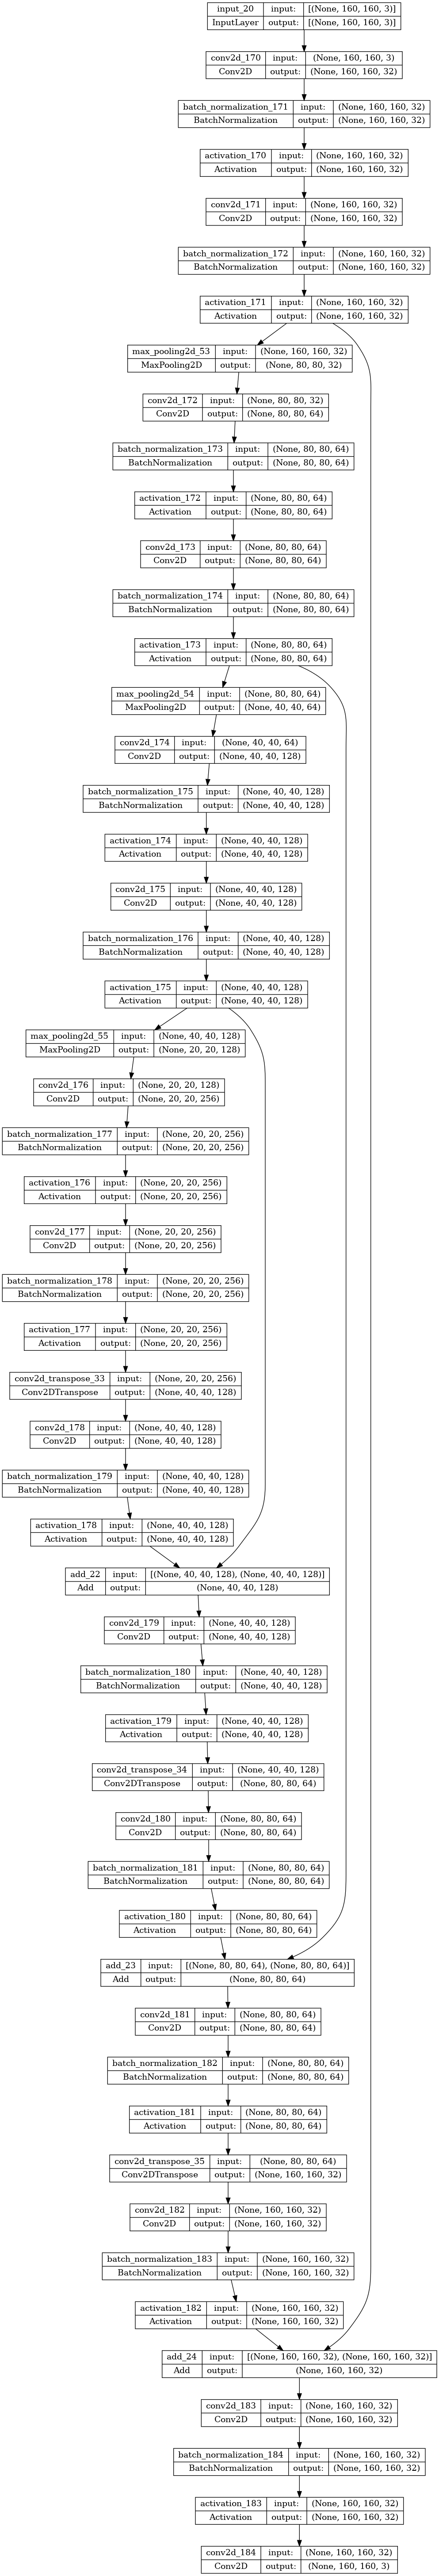

In [111]:
from tensorflow.keras.utils import plot_model

plot_model(model_2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [112]:
model_2.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

epochs = 15
history_2 = model_2.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/15
199/199 [==============================] - 43s 162ms/step - loss: 0.6215 - val_loss: 2.0873
Epoch 2/15
199/199 [==============================] - 32s 160ms/step - loss: 0.4440 - val_loss: 0.5703
Epoch 3/15
199/199 [==============================] - 32s 161ms/step - loss: 0.3873 - val_loss: 0.4417
Epoch 4/15
199/199 [==============================] - 32s 161ms/step - loss: 0.3531 - val_loss: 0.4259
Epoch 5/15
199/199 [==============================] - 32s 160ms/step - loss: 0.3300 - val_loss: 0.3816
Epoch 6/15
199/199 [==============================] - 32s 160ms/step - loss: 0.3143 - val_loss: 0.3760
Epoch 7/15
199/199 [==============================] - 32s 160ms/step - loss: 0.2948 - val_loss: 0.3675
Epoch 8/15
199/199 [==============================] - 32s 160ms/step - loss: 0.2849 - val_loss: 0.3770
Epoch 9/15
199/199 [==============================] - 32s 160ms/step - loss: 0.2720 - val_loss: 0.3379
Epoch 10/15
199/199 [==============================] - 32s 161ms/step - l

31/31 [==============================] - 4s 122ms/step


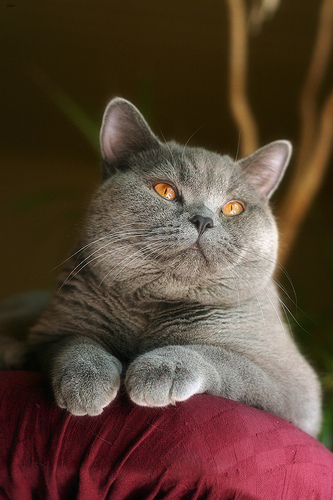

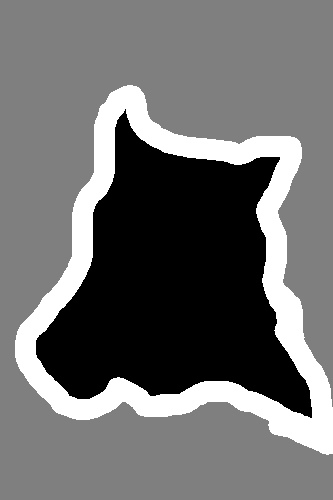

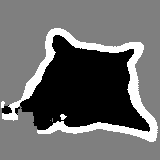

In [113]:
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model_2.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)


i = 10

display(Image(filename=val_input_img_paths[i]))

img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

display_mask(i)